In [1]:
import datasets as hfds

import minai.datasets as minds
import minai.data as mind
import minai.sampler as mins
import minai.plot as minplt

minplt.default_cmap("gray")
minplt.default_title_color("white")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dsd = minds.hf_load(minds.HF_DATASETS.FASHION_MNIST)

Found cached dataset fashion_mnist (/home/nblzv/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tdsd = dsd.with_transform(
    mind.HFTransform.ff_img_decode_to_tensor(mind.first_value(dsd).features),
).cast_column("image", hfds.Image(decode=False))

/home/nblzv/git/fastai_course22p2/minai/minai/data.py:296: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1687158866840/work/torch/csrc/utils/tensor_new.cpp:1505.)
  raw = torch.frombuffer(xs[i]["bytes"], dtype=torch.uint8)


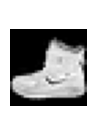

In [5]:
dl = mind.DataLoader.hf(tdsd["train"])
batch = mind.first(dl)
minplt.show_img(batch[0][0], minplt.PlotOpts(title=batch[1][0], figsize=(1, 1)))

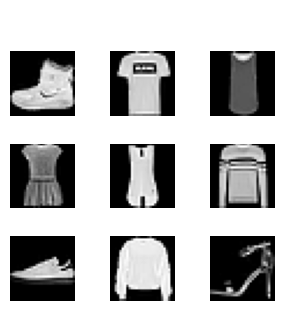

In [6]:
opts = minplt.PlotOpts(rows=3, 
                       cols=3, 
                       figsize=(3, 3),
                       title="Batch",
                       titles=[[x, -x] for x in batch[1]])
minplt.show_batch(batch[0], opts)

In [10]:
dld = mind.DataLoaderDict.hf(tdsd, mins.SIO(16))
dt = dld["train"]
dv = dld["test"]

xb, yb = mind.first(dt)

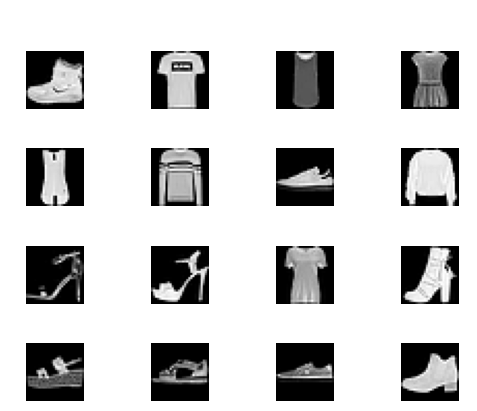

In [26]:
opts = minplt.PlotOpts(rows=4, 
                       cols=4, 
                       figsize=(5, 4),
                       title="Batch",
                       titles=dt.ds.features["label"].int2str(yb),
                       hspace=0.2)
minplt.show_batch(batch[0], opts)